Label and Split

In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
dataset_dir = r"C:\\Users\\prana\\OneDrive\\Documents\\IIC_project\\dataset"
output_dir = r"C:\\Users\\prana\\OneDrive\\Documents\\IIC_project\\split_dataset"

# Create train/val/test directories
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_dir, split, 'Recyclable'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, split, 'Non_Recyclable'), exist_ok=True)

# Split function
def split_data(label):
    images = os.listdir(os.path.join(dataset_dir, label))
    train, temp = train_test_split(images, test_size=0.2, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)
    return train, val, test

for label in ['recyclable', 'non_recyclable']:
    train, val, test = split_data(label)
    for subset, split in zip([train, val, test], ['train', 'val', 'test']):
        for img in subset:
            shutil.copy(os.path.join(dataset_dir, label, img), os.path.join(output_dir, split, label, img))


Preprocess data

Using cache found in C:\Users\prana/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\prana\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Train Loss: 0.3398, Val Loss: 0.0801, Accuracy: 0.9800, Precision: 0.9808, Recall: 0.9800, F1 Score: 0.9800
Epoch 2/20, Train Loss: 0.0419, Val Loss: 0.0396, Accuracy: 0.9800, Precision: 0.9808, Recall: 0.9800, F1 Score: 0.9800
Epoch 3/20, Train Loss: 0.0177, Val Loss: 0.0377, Accuracy: 0.9800, Precision: 0.9808, Recall: 0.9800, F1 Score: 0.9800
Epoch 4/20, Train Loss: 0.0072, Val Loss: 0.0276, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch 5/20, Train Loss: 0.0116, Val Loss: 0.0167, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch 6/20, Train Loss: 0.0030, Val Loss: 0.0309, Accuracy: 0.9800, Precision: 0.9808, Recall: 0.9800, F1 Score: 0.9800
Epoch 7/20, Train Loss: 0.0070, Val Loss: 0.0171, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch 8/20, Train Loss: 0.0057, Val Loss: 0.0139, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch 9/20, Train Loss: 0.0044, Val Loss

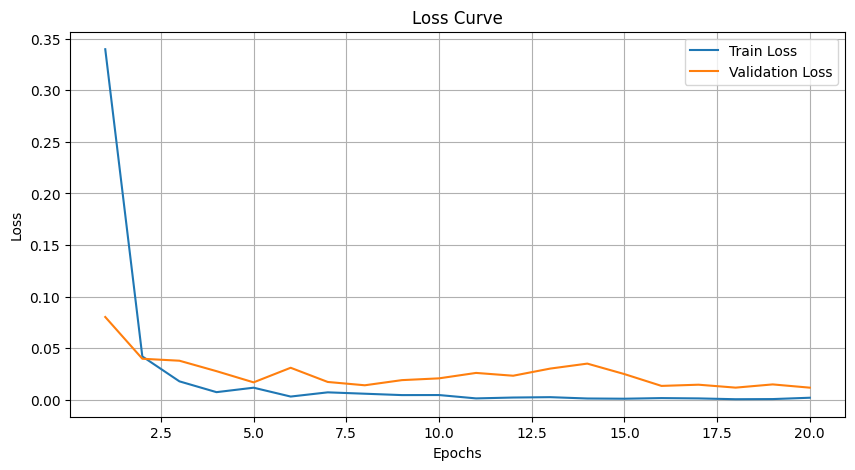

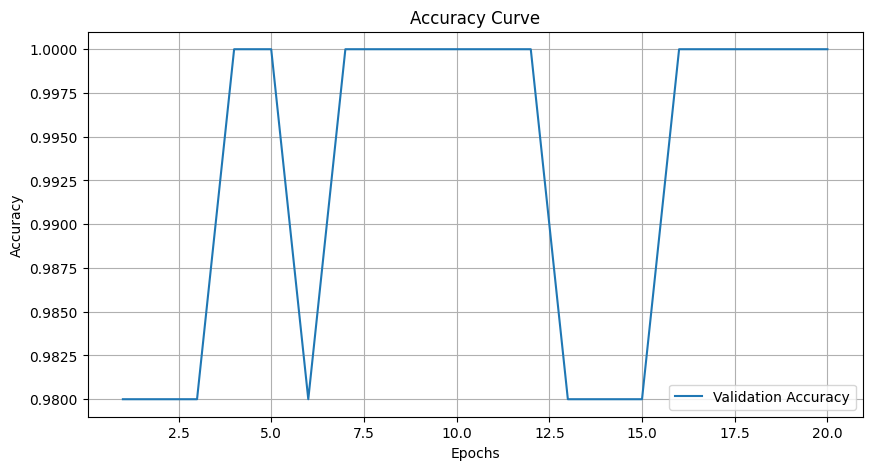

In [10]:
import torch
import torch.nn as nn
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Paths
train_dir = r"C:\\Users\\prana\\OneDrive\\Documents\\IIC_project\\split_dataset\\train"
val_dir = r"C:\\Users\\prana\\OneDrive\\Documents\\IIC_project\\split_dataset\\val"

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load Dataset
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)

# Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Tracking metrics
train_losses = []
val_losses = []
accuracies = []

# Training Loop
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))
    
    # Validation Phase
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    val_losses.append(val_loss / len(val_loader))
    
    # Compute Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Save Model
torch.save(model.state_dict(), 'model.pt')

# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig("loss_curve.png")
plt.show()

# Plot Accuracy Curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), accuracies, label="Validation Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.savefig("accuracy_curve.png")
plt.show()
